In [2]:
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Auto select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------------------------------
# Load metadata
# ---------------------------------------------------
with open("/kaggle/input/cub2002011/CUB_200_2011/train_test_split.txt") as f:
    split = dict(line.strip().split() for line in f)

with open("/kaggle/input/cub2002011/CUB_200_2011/images.txt") as f:
    paths = dict(line.strip().split() for line in f)

with open("/kaggle/input/cub2002011/CUB_200_2011/image_class_labels.txt") as f:
    labels = dict(line.strip().split() for line in f)

# ---------------------------------------------------
# Select only FIRST 5 classes
# ---------------------------------------------------
selected_classes = set(list({int(v) for v in labels.values()})[:200])

print("Using classes:", selected_classes)

train_paths, train_labels = [], []
test_paths, test_labels = [], []

base = "/kaggle/input/cub2002011/CUB_200_2011/images/"

for img_id, rel in paths.items():
    cls = int(labels[img_id])
    if cls not in selected_classes:
        continue

    full = base + rel
    if split[img_id] == "1":
        train_paths.append(full)
        train_labels.append(cls)
    else:
        test_paths.append(full)
        test_labels.append(cls)

print("Train images:", len(train_paths))
print("Test images :", len(test_paths))

# ---------------------------------------------------
# Convert to DataFrames (path + class)
# ---------------------------------------------------
train_df = pd.DataFrame({"path": train_paths, "class": train_labels})
test_df  = pd.DataFrame({"path": test_paths , "class": test_labels})

# ---------------------------------------------------
# Per-class sample counts
# ---------------------------------------------------

train_count = train_df["class"].value_counts().sort_index()
test_count  = test_df["class"].value_counts().sort_index()

print("\n===== TRAIN PER-CLASS COUNTS =====")
print(train_count)

print("\n===== TEST PER-CLASS COUNTS =====")
print(test_count)

print("\n===== SUMMARY =====")
print("Train: classes =", train_count.index.nunique(),
      "| min =", train_count.min(),
      "| max =", train_count.max(),
      "| avg =", train_count.mean())

print("Test : classes =", test_count.index.nunique(),
      "| min =", test_count.min(),
      "| max =", test_count.max(),
      "| avg =", test_count.mean())

# ---------------------------------------------------
# Dataset class with transforms
# ---------------------------------------------------
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class CUBDataset(Dataset):
    def __init__(self, df, transform):
        self.paths = df["path"].values
        self.labels = df["class"].values
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        cls = self.labels[idx] - 1
        return img, cls

# ---------------------------------------------------
# Dataloaders
# ---------------------------------------------------
train_dataset = CUBDataset(train_df, transform_train)
test_dataset = CUBDataset(test_df, transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset , batch_size=32, shuffle=False, num_workers=2)

print("Train loader batches:", len(train_loader))
print("Test loader batches :", len(test_loader))

Using device: cuda
Using classes: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200}
Train images: 5994
Test images : 5794

===== TRAIN PER-CLASS COUNTS =====

Epoch 1/1  Loss = 0.6241

========== METRIC LEARNING EVALUATION ==========
Recall@1 = 0.25595443562305836
Recall@2 = 0.35881946841560236
Recall@4 = 0.4722126337590611
Recall@8 = 0.5921643079047291

NMI = 0.5166590906047793
F1  = 0.005570532032143201

Pairwise Precision = 0.009728441981324517
Pairwise Recall    = 0.9631023296962492


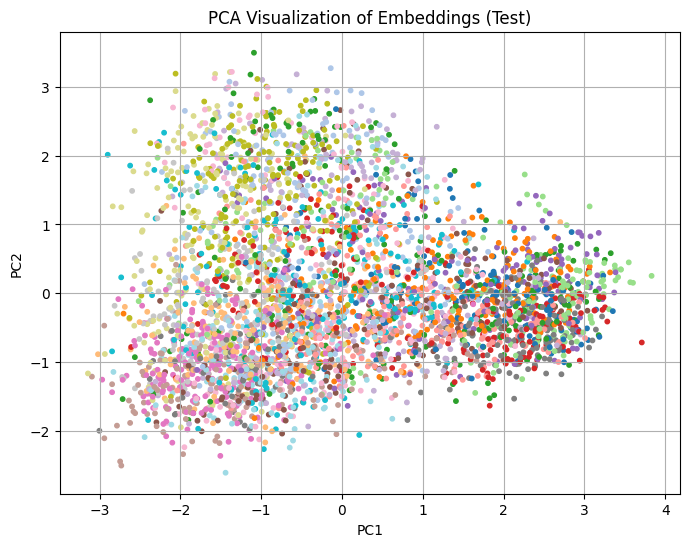

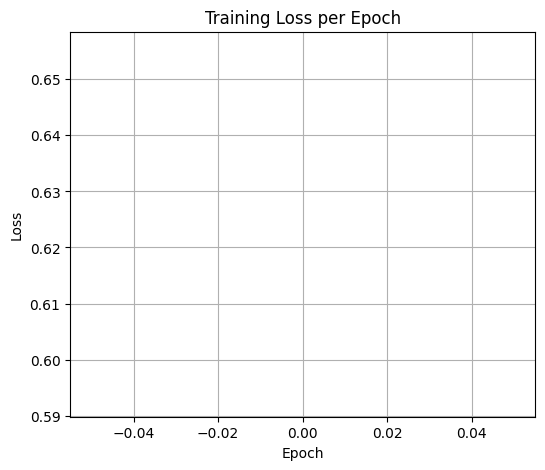

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, f1_score
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ===============================================================
#   SIMPLE ENCODER–DECODER MODEL (NO DVML)
# ===============================================================
class SimpleMetricAutoEncoder(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()

        goog = models.googlenet(weights="IMAGENET1K_V1")

        self.backbone = nn.Sequential(
            goog.conv1, goog.maxpool1,
            goog.conv2, goog.conv3, goog.maxpool2,
            goog.inception3a, goog.inception3b, goog.maxpool3,
            goog.inception4a, goog.inception4b, goog.inception4c,
            goog.inception4d, goog.inception4e,
            goog.maxpool4,
            goog.inception5a, goog.inception5b,
            goog.avgpool
        )

        self.fc_embed = nn.Linear(1024, embed_dim)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024)
        )

    def extract_f(self, x):
        f = self.backbone(x)
        return f.view(f.size(0), -1)

    def forward(self, x):
        f = self.extract_f(x)
        z = self.fc_embed(f)
        f_hat = self.decoder(z)
        return z, f, f_hat


# ===============================================================
#   N-PAIR LOSS
# ===============================================================
class NPairLoss(nn.Module):
    def forward(self, A, P):
        A = F.normalize(A, dim=1)
        P = F.normalize(P, dim=1)
        sim = A @ P.t()
        lbl = torch.arange(len(A), device=sim.device)
        return F.cross_entropy(sim, lbl)


def recon_loss(f, f_hat):
    return F.mse_loss(f_hat, f)


# ===============================================================
#   MODEL INIT
# ===============================================================
model = SimpleMetricAutoEncoder(embed_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
npair = NPairLoss()


# ===============================================================
#   TRAIN LOOP
# ===============================================================
loss_list = []
EPOCHS = 10   # ← SET EPOCH COUNT HERE

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        z, f, f_hat = model(imgs)

        # Build N-pair A,P pairs
        A, P = [], []
        for c in labels.unique():
            idx = (labels == c).nonzero().flatten()
            if len(idx) >= 2:
                A.append(z[idx[0]])
                P.append(z[idx[1]])

        if len(A) == 0:
            continue

        A = torch.stack(A)
        P = torch.stack(P)

        loss = npair(A, P) + recon_loss(f, f_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    loss_list.append(epoch_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}  Loss = {epoch_loss:.4f}")


# ===============================================================
#   EXTRACT EMBEDDINGS
# ===============================================================
def extract_embeddings(model, loader):
    E, L = [], []
    model.eval()

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            z, _, _ = model(imgs)
            E.append(z.cpu())
            L.append(lbls.cpu())

    return torch.cat(E), torch.cat(L)


# ===============================================================
#   EVALUATION METRICS
# ===============================================================
def recall_at_k(E, L, K=1):
    E = F.normalize(E, dim=1)
    sim = E @ E.t()

    N = len(L)
    sim[range(N), range(N)] = -1

    _, idx = sim.topk(K, dim=1)
    return sum(L[i] in L[idx[i]] for i in range(N)) / N


def clustering_metrics(E, L, num_classes):
    km = KMeans(n_clusters=num_classes, n_init=10)
    clusters = km.fit_predict(E)
    nmi = normalized_mutual_info_score(L, clusters)
    f1 = f1_score(L, clusters, average="macro")
    return nmi, f1


def pairwise_precision_recall(E, L):
    D = pairwise_distances(E)
    y_true = (L[:, None] == L[None, :]).astype(int)
    thr = np.median(D)
    y_pred = (D < thr).astype(int)

    TP = (y_pred * y_true).sum()
    FP = (y_pred * (1 - y_true)).sum()
    FN = ((1 - y_pred) * y_true).sum()

    prec = TP / (TP + FP + 1e-9)
    rec  = TP / (TP + FN + 1e-9)
    return prec, rec


# ===============================================================
#   RUN EVALUATION
# ===============================================================
E, L = extract_embeddings(model, test_loader)
num_classes = len(torch.unique(L))

print("\n========== METRIC LEARNING EVALUATION ==========")
for k in [1,2,4,8]:
    print(f"Recall@{k} =", recall_at_k(E, L, k))

nmi, f1 = clustering_metrics(E.numpy(), L.numpy(), num_classes)
print("\nNMI =", nmi)
print("F1  =", f1)

prec, rec = pairwise_precision_recall(E.numpy(), L.numpy())
print("\nPairwise Precision =", prec)
print("Pairwise Recall    =", rec)


# ===============================================================
#   PCA VISUALIZATION
# ===============================================================
def plot_pca_clusters(E, L, num_samples=4000):
    E = E.numpy()
    L = L.numpy()

    if len(E) > num_samples:
        idx = np.random.choice(len(E), num_samples, replace=False)
        E = E[idx]
        L = L[idx]

    X = PCA(n_components=2).fit_transform(E)

    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=L, cmap="tab20", s=10)
    plt.title("PCA Visualization of Embeddings (Test)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()


plot_pca_clusters(E, L)

Epoch 1/1 | Loss = 1.4158

========== DVML EVALUATION ==========
Recall@1 0.2625129444252675
Recall@2 0.361408353469106
Recall@4 0.48118743527787367
Recall@8 0.5997583707283397
NMI: 0.5121538282522219
F1 : 0.004704649490677545
Precision: 0.009229193118515722
Recall: 0.913677381303445


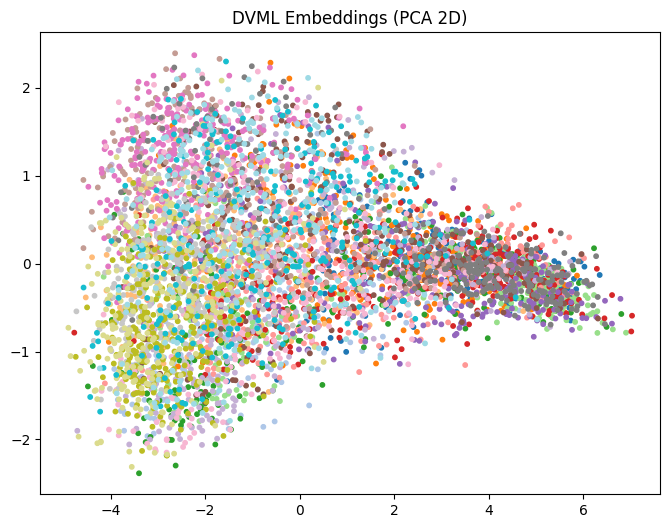

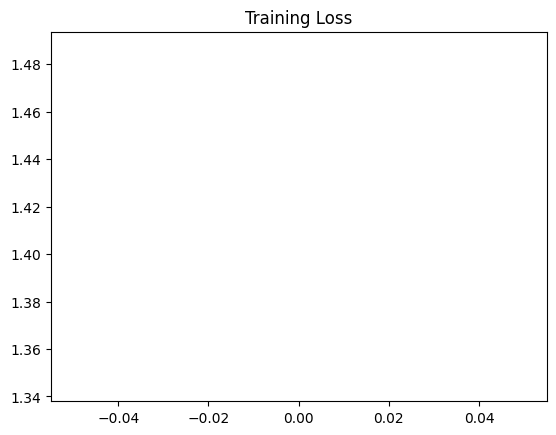

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, f1_score
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
#                 DVML MODEL (ECCV 2018)
# ============================================================

class DVML(nn.Module):
    def __init__(self, embed_dim=128, var_dim=128):
        super().__init__()

        goog = models.googlenet(weights="IMAGENET1K_V1")

        self.backbone = nn.Sequential(
            goog.conv1, goog.maxpool1,
            goog.conv2, goog.conv3, goog.maxpool2,
            goog.inception3a, goog.inception3b, goog.maxpool3,
            goog.inception4a, goog.inception4b, goog.inception4c,
            goog.inception4d, goog.inception4e,
            goog.maxpool4,
            goog.inception5a, goog.inception5b,
            goog.avgpool
        )

        self.fc_mu = nn.Linear(1024, embed_dim)
        self.fc_logvar = nn.Linear(1024, var_dim)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024)
        )

    def encode(self, x):
        f = self.backbone(x)
        f = f.view(f.size(0), -1)
        mu = self.fc_mu(f)
        logvar = self.fc_logvar(f)
        return mu, logvar, f

    def sample(self, mu, logvar, noise_scale=1.0):
        std = torch.exp(0.5 * logvar) * noise_scale
        eps = torch.randn_like(std)
        return mu + eps * std   # z_V

    def forward(self, x, noise_scale=1.0):
        mu, logvar, f = self.encode(x)
        z_i = mu
        z_v = self.sample(mu, logvar, noise_scale)
        f_hat = self.decoder(z_i)
        return z_i, z_v, mu, logvar, f, f_hat


# ============================================================
#                     N-PAIR LOSS
# ============================================================

class NPairLoss(nn.Module):
    def forward(self, A, P):
        A = F.normalize(A, dim=1)
        P = F.normalize(P, dim=1)

        sim = A @ P.t()
        targets = torch.arange(len(A), device=sim.device)

        return F.cross_entropy(sim, targets)


def build_pairs(z, labels):
    A, P = [], []
    for c in labels.unique():
        idx = (labels == c).nonzero().flatten()
        if len(idx) >= 2:
            A.append(z[idx[0]])
            P.append(z[idx[1]])

    if len(A) == 0:
        return None, None

    return torch.stack(A), torch.stack(P)


def kl_loss(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())


def recon_loss(f, f_hat):
    return F.mse_loss(f_hat, f)


# ============================================================
#                     TRAINING
# ============================================================

model = DVML(embed_dim=128, var_dim=128).to(device)
npair = NPairLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
loss_list = []

for epoch in range(num_epochs):
    model.train()

    kl_w = min(1.0, epoch / 10)
    noise_scale = max(0.3, 1.0 - epoch/10)

    epoch_loss = 0
    count = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        z_i, z_v, mu, logvar, f, f_hat = model(imgs, noise_scale)

        A_i, P_i = build_pairs(z_i, labels)
        A_v, P_v = build_pairs(z_v, labels)

        if A_i is None: 
            continue

        L_np_i = npair(A_i, P_i)
        L_np_v = npair(A_v, P_v)

        L_rec = recon_loss(f, f_hat)
        L_kl = kl_loss(mu, logvar)

        loss = L_np_i + L_np_v + L_rec + kl_w * L_kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        count += 1

    avg_loss = epoch_loss / count
    loss_list.append(avg_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss = {avg_loss:.4f}")


# ============================================================
#                EXTRACT DVML EMBEDDINGS (using z_I)
# ============================================================

def extract_embeddings(model, loader):
    E, L = [], []
    model.eval()
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            z_i, _, _, _, _, _ = model(imgs, noise_scale=0.0)
            E.append(z_i.cpu())
            L.append(lbls.cpu())

    return torch.cat(E), torch.cat(L)


# ============================================================
#                 METRIC LEARNING EVALUATION
# ============================================================

def recall_at_k(E, L, K=1):
    E = F.normalize(E, dim=1)
    S = E @ E.t()
    N = len(L)
    S[range(N), range(N)] = -1

    _, idx = S.topk(K, dim=1)
    return sum(L[i] in L[idx[i]] for i in range(N)) / N


def clustering_metrics(E, L, num_classes):
    km = KMeans(n_clusters=num_classes, n_init=10)
    C = km.fit_predict(E)
    nmi = normalized_mutual_info_score(L, C)
    f1  = f1_score(L, C, average="macro")
    return nmi, f1


def pairwise_precision_recall(E, L):
    D = pairwise_distances(E)
    y_true = (L[:, None] == L[None, :]).astype(int)
    thr = np.median(D)
    y_pred = (D < thr).astype(int)

    TP = (y_pred * y_true).sum()
    FP = (y_pred * (1 - y_true)).sum()
    FN = ((1 - y_pred) * y_true).sum()

    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)
    return precision, recall


# ============================================================
#                        PCA
# ============================================================

def plot_pca(E, L):
    pca = PCA(n_components=2)
    X = pca.fit_transform(E)

    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=L, cmap="tab20", s=10)
    plt.title("DVML Embeddings (PCA 2D)")
    plt.show()


# ============================================================
#                     RUN EVALUATION
# ============================================================

E, L = extract_embeddings(model, test_loader)
E_np, L_np = E.numpy(), L.numpy()
num_classes = len(torch.unique(L))

print("\n========== DVML EVALUATION ==========")

for k in [1,2,4,8]:
    print(f"Recall@{k}", recall_at_k(E, L, k))

nmi, f1 = clustering_metrics(E_np, L_np, num_classes)
print("NMI:", nmi)
print("F1 :", f1)

prec, rec = pairwise_precision_recall(E_np, L_np)
print("Precision:", prec)
print("Recall:", rec)

plot_pca(E_np, L_np)